In [1]:
import numpy as np
import pandas as pd
import os

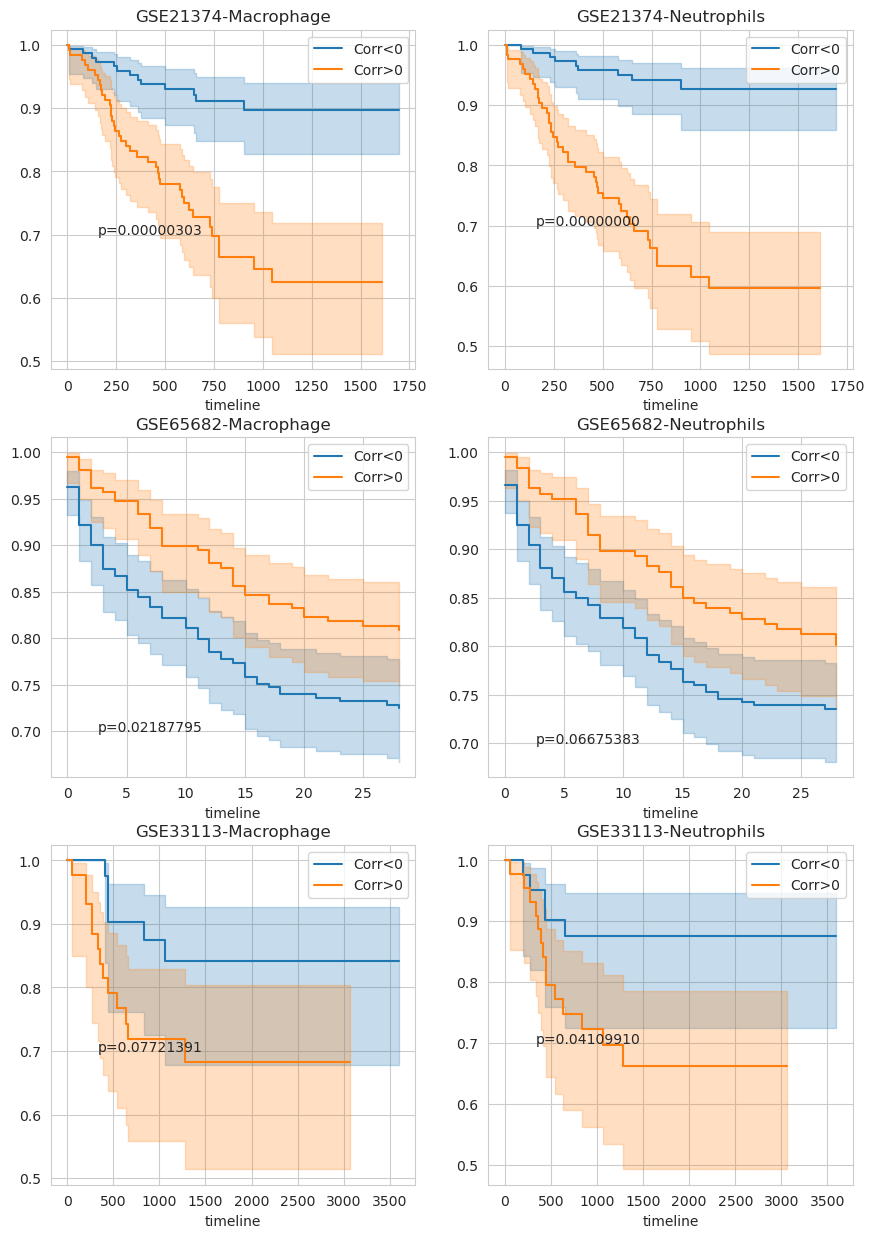

In [4]:
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

celltype_list = ['Macrophage', 'Neutrophils']
# dataset_list = ["GSE14333", "GSE15654", "GSE17538", "GSE21374", "GSE28221", "GSE65218", "GSE65682", "GSE112927", "GSE33113", "GSE31595"]
dataset_list = ["GSE21374", "GSE65682", "GSE33113"]
fig = plt.figure(figsize=(8 * len(celltype_list), 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=math.ceil(len(dataset_list)), ncols=3, width_ratios=[1, 1, 1])
j = 0
for celltype in celltype_list:
    for i in range(len(dataset_list)):
        dataset = dataset_list[i]
        output_dir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/4.Macrophage_analysis/{dataset}/survival'
        
        tres_signature_tag = f'Tres_signature_2.positive'
        survival_path = os.path.join(output_dir, f'{dataset}.{celltype}.{tres_signature_tag}.csv')
        survival_df = pd.read_csv(survival_path).dropna(how='any')
        
        ax = fig.add_subplot(gs[i, j])
        kmf = KaplanMeierFitter() # KM初始化
        for group_name, group_data in survival_df.groupby(f'corr_group_2'):
        # for group_name, group_data in survival_df.groupby(f'mse_group'):
            kmf.fit(group_data["time"], group_data["death"], label=group_name)
            kmf.plot_survival_function()
                
        flag = (survival_df[f'corr_group_2'] == 'Corr>0')
        # flag = (survival_df[f'mse_group'] == 'mse_high')
        time = survival_df["time"]
        death = survival_df["death"]
        results = logrank_test(time[flag], time[~flag], death[flag], death[~flag], alpha=.99)
        ax.set_title(f"{dataset}-{celltype}")
        ax.text(max(time) / 4, 0.7, f'p={"{:.8f}".format(results.p_value)}', ha='center', fontsize=10)
    j += 1
plt.show()

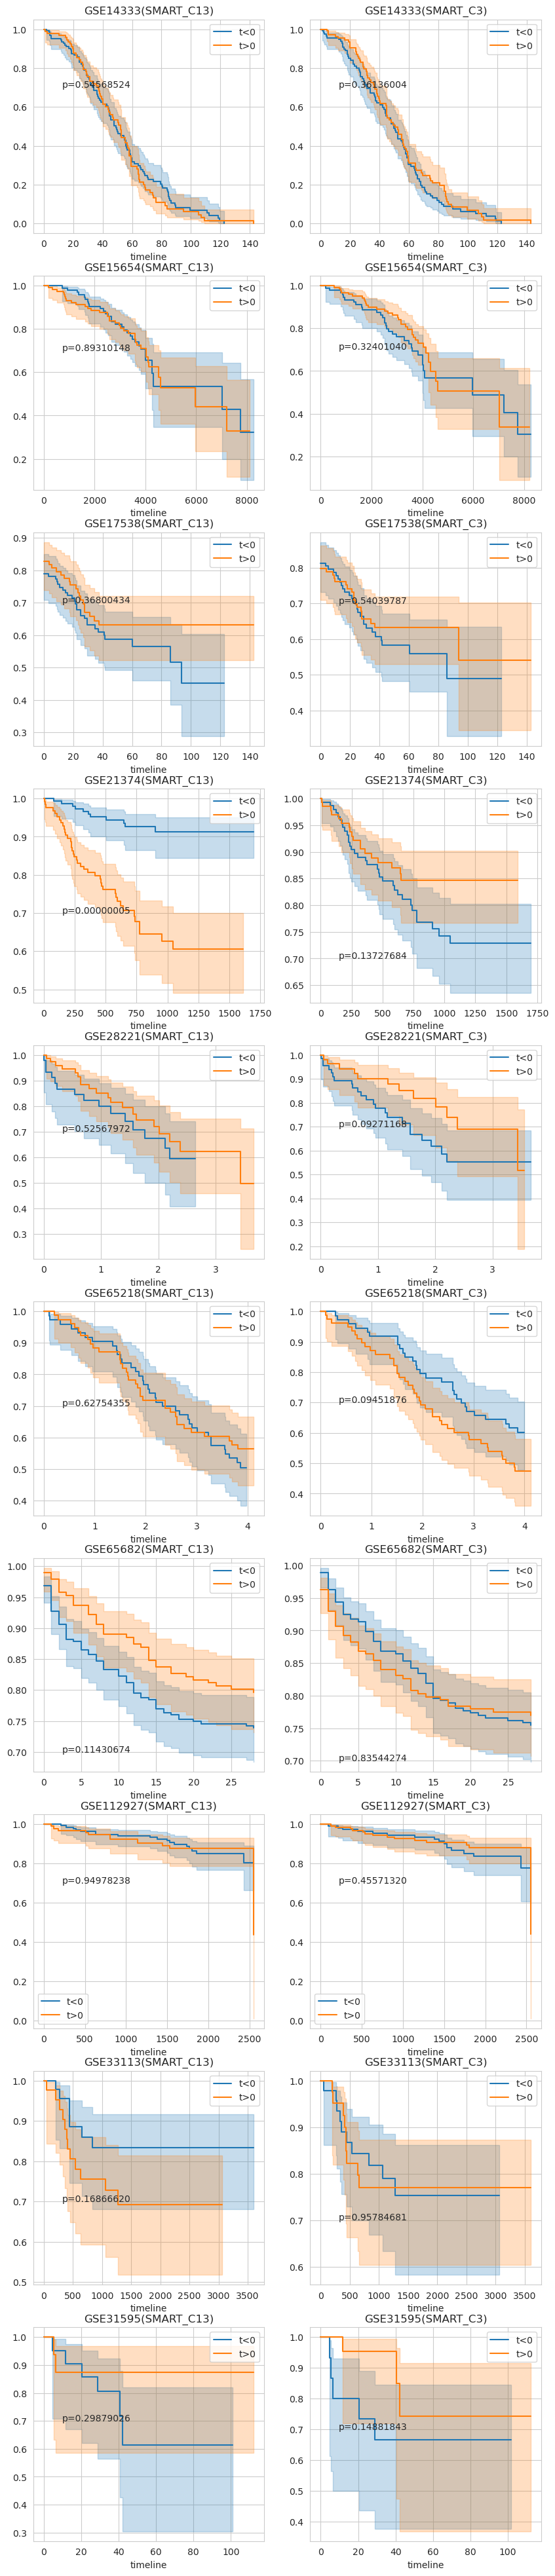

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# get bulk response survival data
dataset_list = ["GSE14333", "GSE15654", "GSE17538", "GSE21374", "GSE28221", "GSE65218", "GSE65682", "GSE112927", "GSE33113", "GSE31595"]
fig = plt.figure(figsize=(10, 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=2, width_ratios=[1, 1])
for i in range(len(dataset_list)):
    dataset = dataset_list[i]
    output_dir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/4.Macrophage_analysis/{dataset}'
    survival_path = os.path.join(output_dir, f'{dataset}.survival.csv')
    survival_df = pd.read_csv(survival_path).dropna(how='any')
    
    j = 0
    # for signature_name in ['negative_down100', 'negative_top100', 'positive_down100', 'positive_top100']:
    for signature_name in ['SMART_C13', 'SMART_C3']:
    # for signature_name in ['Polarization']:
        ax = fig.add_subplot(gs[i, j])
        j += 1
        
        signature_key = signature_name.split('_')[-1] + '_response'
        kmf = KaplanMeierFitter() # KM初始化
        for group_name, group_data in survival_df.groupby(f'{signature_key}_group'):
            kmf.fit(group_data["time"], group_data["death"], label=group_name)
            kmf.plot_survival_function()
                
        flag = (survival_df[f'{signature_key}_group'] == 't>0')
        # flag = (survival_df[f'{signature_key}_group'] == 'high')
        time = survival_df["time"]
        death = survival_df["death"]
        results = logrank_test(time[flag], time[~flag], death[flag], death[~flag], alpha=.99)
        ax.set_title(f"{dataset}({signature_name})")
        ax.text(max(time) / 4, 0.7, f'p={"{:.8f}".format(results.p_value)}', ha='center', fontsize=10)
plt.show()

In [24]:
# Cox模型求系数和p值
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import CoxPHFitter

# get bulk response survival data
dataset_list = ["GSE28221"]
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=1, height_ratios=[1])
for i in range(len(dataset_list)):
    dataset = dataset_list[i]
    output_dir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/4.Macrophage_analysis/{dataset}'
    
survival_path = os.path.join(output_dir, f'{dataset}.survival.csv')
survival_df = pd.read_csv(survival_path, index_col=0, header=0).dropna(how='any')
survival_df_subset = survival_df[['correlation_2', 'time', 'death', 'C13_response']]
survival_df_subset['multiple'] = survival_df_subset['correlation_2'] * survival_df_subset['C13_response']
    
cph = CoxPHFitter()
cph.fit(survival_df_subset, duration_col='time', event_col='death')
cph.summary
    
#     ax = fig.add_subplot(gs[i, 0])
#     ax.set_title(f"{dataset}")
#     ax.text(max(time) / 4, 0.65, f'p={"{:.8f}".format(results.p_value)}', ha='center', fontsize=15)
# plt.show()

/tmp/ipykernel_149160/3469263635.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df_subset['multiple'] = survival_df_subset['correlation_2'] * survival_df_subset['C13_response']


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
correlation_2,0.894042,2.444992,12.416890,-23.442614,25.230698,6.591768e-11,9.068867e+10,0.0,0.072002,0.942600,0.085282
C13_response,-0.046202,0.954849,0.430538,-0.890040,0.797636,4.106392e-01,2.220287e+00,0.0,-0.107312,0.914541,0.128880
multiple,0.712189,2.038448,1.169388,-1.579770,3.004148,2.060224e-01,2.016902e+01,0.0,0.609027,0.542507,0.882287


<Figure size 1000x1000 with 0 Axes>

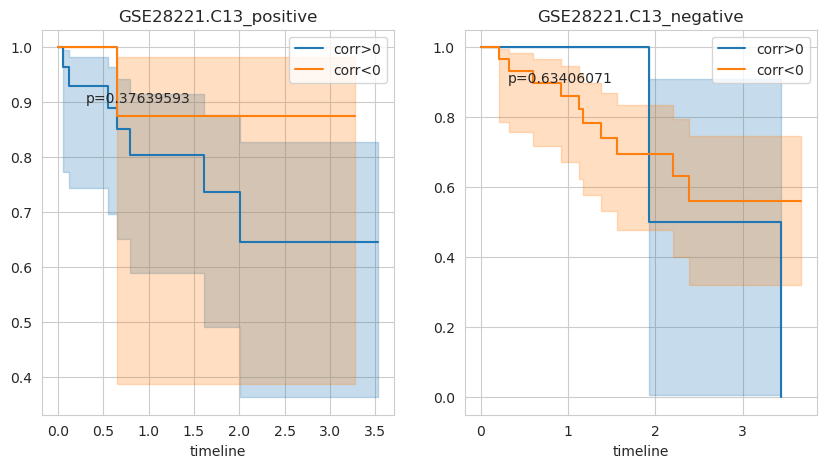

In [191]:
# 对C13分组绘制Corr的分组KM图
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import CoxPHFitter

# get bulk response survival data
dataset_list = ["GSE28221"]
fig = plt.figure(figsize=(10, len(dataset_list) * 5))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=2, width_ratios=[1, 1])
for i in range(len(dataset_list)):
    dataset = dataset_list[i]
    output_dir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/4.Macrophage_analysis/{dataset}'
    
    survival_path = os.path.join(output_dir, f'{dataset}.survival.csv')
    survival_df = pd.read_csv(survival_path, index_col=0, header=0).dropna(how='any')
    C13_positive = survival_df[survival_df['C13_response'] > 0]
    C13_negative = survival_df[survival_df['C13_response'] < 0]
    
    j = 0
    for plot_name in ['C13_positive', 'C13_negative']:
        ax = fig.add_subplot(gs[i, j])
        j += 1
        
        if plot_name == 'C13_positive':
            survival_df = C13_positive
        else:
            survival_df = C13_negative
            
        kmf = KaplanMeierFitter() # KM初始化
        high_flag = (survival_df[f'correlation_2'] > 0)
        corr_high = survival_df[high_flag]
        kmf.fit(corr_high["time"], corr_high["death"], label='corr>0')
        kmf.plot_survival_function()
        corr_low = survival_df[~high_flag]
        kmf.fit(corr_low["time"], corr_low["death"], label='corr<0')
        kmf.plot_survival_function()

        time = survival_df["time"]
        death = survival_df["death"]
        results = logrank_test(time[high_flag], time[~high_flag], death[high_flag], death[~high_flag], alpha=.99)
        ax.set_title(f"{dataset}.{plot_name}")
        ax.text(max(time) / 4, 0.9, f'p={"{:.8f}".format(results.p_value)}', ha='center', fontsize=10)
plt.show()

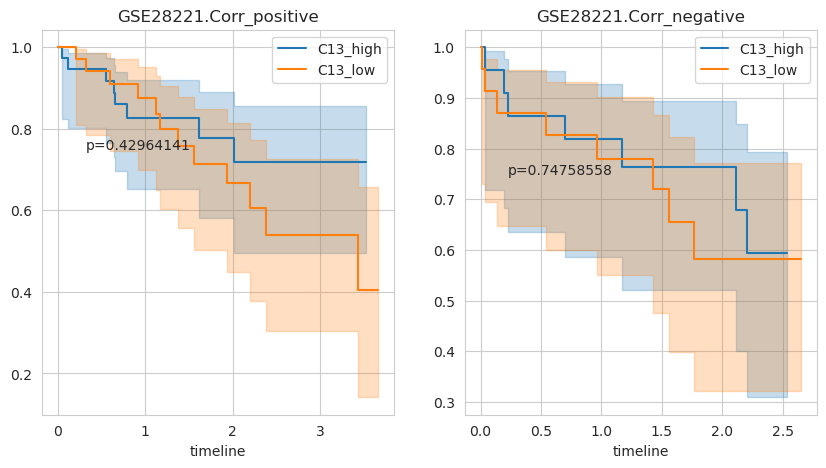

In [186]:
# 对C13分组绘制Corr的分组KM图
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import CoxPHFitter

# get bulk response survival data
dataset_list = ["GSE28221"]
fig = plt.figure(figsize=(10, len(dataset_list) * 5))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=2, width_ratios=[1, 1])
for i in range(len(dataset_list)):
    dataset = dataset_list[i]
    output_dir = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/4.Macrophage_analysis/{dataset}'
    
    survival_path = os.path.join(output_dir, f'{dataset}.survival.csv')
    survival_df = pd.read_csv(survival_path, index_col=0, header=0).dropna(how='any')
    Corr_positive = survival_df[survival_df['corr_group_2'] == 'Corr>0']
    Corr_negative = survival_df[survival_df['corr_group_2'] == 'Corr<0']
    
    j = 0
    for plot_name in ['Corr_positive', 'Corr_negative']:
        ax = fig.add_subplot(gs[i, j])
        j += 1
        
        if plot_name == 'Corr_positive':
            survival_df = Corr_positive
        else:
            survival_df = Corr_negative
            
        kmf = KaplanMeierFitter() # KM初始化
        
        high_flag = survival_df['C13_response'] > np.median(survival_df['C13_response'])
        C13_high = survival_df[high_flag]
        kmf.fit(C13_high["time"], C13_high["death"], label='C13_high')
        kmf.plot_survival_function()
        C13_low = survival_df[~high_flag]
        kmf.fit(C13_low["time"], C13_low["death"], label='C13_low')
        kmf.plot_survival_function()
            
        time = survival_df["time"]
        death = survival_df["death"]
        results = logrank_test(time[high_flag], time[~high_flag], death[high_flag], death[~high_flag], alpha=.99)
        ax.set_title(f"{dataset}.{plot_name}")
        ax.text(max(time) / 4, 0.75, f'p={"{:.8f}".format(results.p_value)}', ha='center', fontsize=10)
plt.show()

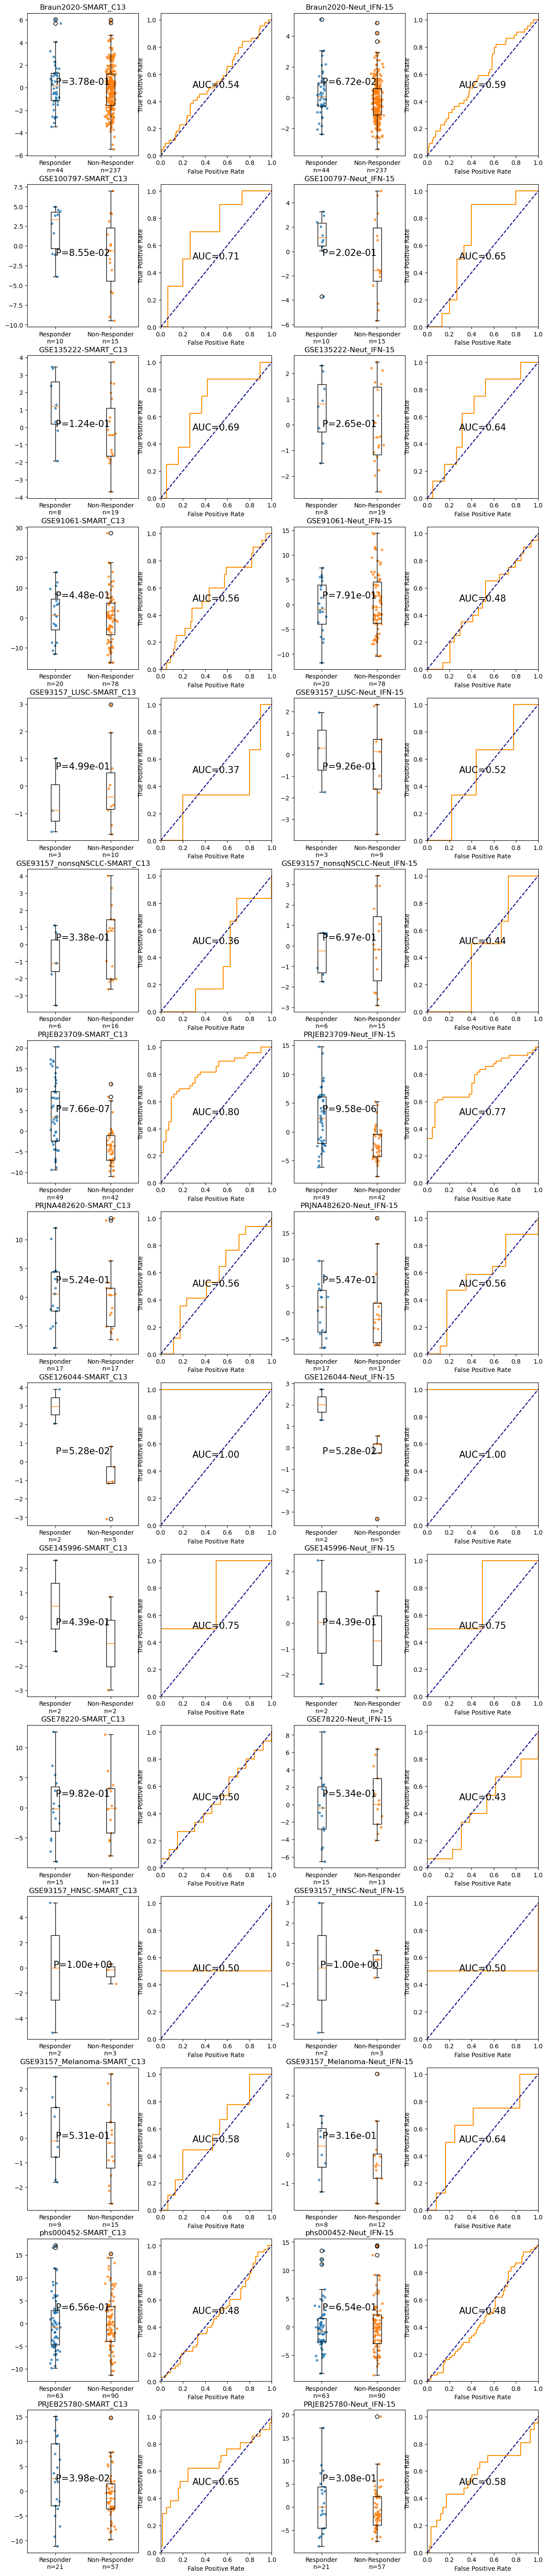

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import ranksums
from sklearn import metrics

dataset_list = ["Braun2020", "GSE100797", "GSE135222", "GSE91061", "GSE93157_LUSC", "GSE93157_nonsqNSCLC", "PRJEB23709", "PRJNA482620", "GSE126044", "GSE145996", "GSE78220", "GSE93157_HNSC", "GSE93157_Melanoma", "phs000452", "PRJEB25780"]
fig = plt.figure(figsize=(15, 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=4, width_ratios=[1, 1, 1, 1])
for signature_name in ['SMART_C13', 'Neut_IFN-15']:
    for i in range(len(dataset_list)):
        dataset = dataset_list[i]
        # print(f"Process {dataset}")
        bulk_response_path = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.bulk_response.csv'
        bulk_response_df = pd.read_csv(bulk_response_path, header=0, index_col=0, delimiter='\t')
        
        sample_annotation_path = f'/sibcb1/bioinformatics/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.Response.tsv'
        sample_annotation_df = pd.read_csv(sample_annotation_path, delimiter='\t', header=0, index_col=0)
        sample_annotation_df.set_index('sample_id', inplace=True)
        
        response_correlation = bulk_response_df.loc[signature_name][sample_annotation_df[sample_annotation_df['response_NR'] == 'R'].index].dropna()
        nonresponse_correlation = bulk_response_df.loc[signature_name][sample_annotation_df[sample_annotation_df['response_NR'] == 'N'].index].dropna()
        # NR_flag = (sample_annotation_df['response'].isin(['PD', 'N']))
        # response_correlation = bulk_response_df.loc[signature_name][sample_annotation_df[~NR_flag].index].dropna()
        # nonresponse_correlation = bulk_response_df.loc[signature_name][sample_annotation_df[NR_flag].index].dropna()
        if len(response_correlation) == 0 or len(nonresponse_correlation) == 0:
            print(f'{dataset} fail')
            continue
            
        correlation_data = [np.array(response_correlation).ravel(), np.array(nonresponse_correlation).ravel()]
        p_value = ranksums(response_correlation, nonresponse_correlation).pvalue
        p_value_format = format(p_value, '0.2e')
        
        if signature_name == 'SMART_C13':
            ax1 = fig.add_subplot(gs[i, 0])
            ax2 = fig.add_subplot(gs[i, 1])
        elif signature_name == 'Neut_IFN-15':
            ax1 = fig.add_subplot(gs[i, 2])
            ax2 = fig.add_subplot(gs[i, 3])
    
        ax1.boxplot(correlation_data)
        # add scatter
        for i in range(len(correlation_data)):
            y = correlation_data[i]
            x = np.random.normal(i + 1, 0.04, size=len(y))
            ax1.scatter(x, y, alpha=0.7, s=10)
        y_mean = (max(max(row) for row in correlation_data) + min(min(row) for row in correlation_data)) / 2
        ax1.text(1.5, y_mean, f'P={p_value_format}', ha='center', fontsize=15)
        ax1.set_xticks([1, 2])
        ax1.set_xticklabels([f'Responder\nn={len(response_correlation)}', f'Non-Responder\nn={len(nonresponse_correlation)}'])
    
        # calculate ROC
        y_true = [1] * len(response_correlation) + [0] * len(nonresponse_correlation)
        y_pred = list(correlation_data[0]) + list(correlation_data[1])
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
    
        ax2.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc})')
        ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
        ax2.text(0.5, 0.5, f'AUC={"{:.2f}".format(roc_auc)}', ha='center', fontsize=15)
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
    
        ax1.set_title(f'{dataset}-{signature_name}')
plt.show()